In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
import sys
from pycocotools.coco import COCO
import urllib
import zipfile 
import matplotlib.pyplot as plt 
import skimage.io as io 
import numpy as np 
%matplotlib inline 

!pip install nltk
import nltk
nltk.download('punkt')


import pickle
import os.path
from collections import Counter

from PIL import Image
from tqdm import tqdm
import random
import json
import math

from torchvision import transforms
import torch
import torch.utils.data as data
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
os.makedirs('coco_dataset' , exist_ok=True)
os.chdir( 'coco_dataset/' )
!git clone 'https://github.com/cocodataset/cocoapi.git'

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 17.05 MiB/s, done.
Resolving deltas: 100% (576/576), done.


Download the Annotations and Captions :

In [4]:
%cd ..

/content


In [5]:
annotations_trainval2014 = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
image_info_test2014 = 'http://images.cocodataset.org/annotations/image_info_test2014.zip'

urllib.request.urlretrieve(annotations_trainval2014 , filename = 'coco_dataset/annotations_trainval2014.zip' )
urllib.request.urlretrieve(image_info_test2014 , filename= 'coco_dataset/image_info_test2014.zip' )

('coco_dataset/image_info_test2014.zip',
 <http.client.HTTPMessage at 0x7f7e218c6c10>)

In [6]:
with zipfile.ZipFile('coco_dataset/annotations_trainval2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( 'coco_dataset/cocoapi'  )  
os.remove( 'coco_dataset/annotations_trainval2014.zip' )

with zipfile.ZipFile('coco_dataset/image_info_test2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( 'coco_dataset/cocoapi'  )  
os.remove( 'coco_dataset/image_info_test2014.zip' )

In [7]:
os.chdir('coco_dataset/cocoapi/annotations')

coco = COCO('instances_val2014.json')
cococp = COCO('captions_val2014.json')

ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=6.42s)
creating index...
index created!
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


In [8]:
%cd ../../..

/content


A table topped with a multi layered cake.
The item in the photograph appears to be fascinating. 

A round table with with small pastries and a cake in the middle.
a table with a wedding cake sitting next to an archway with some lights on it 
A three tiered cake is on a table under an arch. 


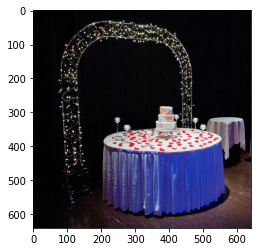

In [9]:
id = coco.anns[np.random.choice( ids )]['image_id']
img = coco.loadImgs(id)[0]
plt.imshow(io.imread(img['coco_url']))

annId = cococp.getAnnIds(id)
ann = cococp.loadAnns(annId)
cococp.showAnns(ann)

In [10]:
%cd ..

/


In [11]:
#urllib.request.urlretrieve( 'http://images.cocodataset.org/zips/train2014.zip', 'content/drive/MyDrive/deep_learning/HW4/train.zip' )
urllib.request.urlretrieve( 'http://images.cocodataset.org/zips/test2014.zip', 'content/coco_dataset/cocoapi/test.zip' )

('content/coco_dataset/cocoapi/test.zip',
 <http.client.HTTPMessage at 0x7f7de7179880>)

In [12]:
with zipfile.ZipFile( 'content/drive/MyDrive/deep_learning/HW4/train.zip' , 'r' ) as zip_ref:
  zip_ref.extractall( 'content/coco_dataset/cocoapi/images' )

with zipfile.ZipFile( 'content/coco_dataset/cocoapi/test.zip' , 'r' ) as zip_ref:
  zip_ref.extractall( 'content/coco_dataset/cocoapi/images' )
os.remove( 'content/coco_dataset/cocoapi/test.zip' )


In [64]:
class Vocab(object):
    def __init__(self,vocab_threshold,vocab_file='./vocab.pkl',annotations_file = '', read_from_file = True):

        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = "<start>"
        self.end_word = "<end>"
        self.unk_word = "<unk>"
        self.annotations_file = annotations_file
        self.read_from_file = read_from_file
        self.get_vocab()

    def get_vocab(self):
        if os.path.exists(self.vocab_file) and self.read_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in tqdm(enumerate(ids)):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [66]:
def get_loader(transform,mode='train',batch_size=1,vocab_threshold=None, read_from_file = True):
    
    if mode == 'train':
        img_folder = os.path.join('content/coco_dataset/cocoapi/images/train2014/')
        annotations_file = os.path.join('content/coco_dataset/cocoapi/annotations/captions_train2014.json')
    elif mode == 'test':
        img_folder = os.path.join('content/coco_dataset/cocoapi/images/test2014/')
        annotations_file = os.path.join('content/coco_dataset/cocoapi/annotations/image_info_test2014.json')

    dataset = CoCoDS(transform=transform,mode=mode,batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          annotations_file=annotations_file,img_folder=img_folder, read_from_file=read_from_file)

    if mode == 'train':
        indices = dataset.get_train_indices()
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader = data.DataLoader(dataset=dataset, num_workers=0,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,batch_size=dataset.batch_size,drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,batch_size=dataset.batch_size,shuffle=True,num_workers=0)

    return data_loader

class CoCoDS(data.Dataset):
    def __init__(self, transform, mode, batch_size, vocab_threshold,  annotations_file, img_folder, read_from_file = True):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocab(vocab_threshold, './vocab.pkl',annotations_file, read_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':            
            self.coco = COCO(annotations_file)

            self.ids = list(self.coco.anns.keys())
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
        
    def __getitem__(self, index):

        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()
            return image, caption

        else:
            path = self.paths[index]
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

In [67]:
transform_train = transforms.Compose([ transforms.Resize(256), transforms.RandomCrop(224),                      
    transforms.RandomHorizontalFlip(),         transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

data_loader_train = get_loader(transform=transform_train,mode='train',batch_size=64,vocab_threshold=8, read_from_file = False)

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!


414113it [00:37, 11001.67it/s]


loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


100%|██████████| 414113/414113 [00:42<00:00, 9682.05it/s] 


In [81]:
counter = Counter(data_loader_train.dataset.caption_lengths)
lengths = sorted( counter.items() , key = lambda pair : pair[1] , reverse=True )
for val,count in lengths:
  if count < 10000: 
    break
indices = data_loader_train.dataset.get_train_indices()
sampler = data.sampler.SubsetRandomSampler(  indices )
data_loader_train.batch_sampler.sampler = sampler 
images , captions = next(iter(data_loader_train))

In [69]:
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super(Encoder, self).__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        for param in resnet.parameters():
            param.requires_grad_(True)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)        
        features = features.view(features.size(0), -1)        
        features = self.embed(features)        
        return features
    

In [70]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EMB_SIZE = 256
encoder = Encoder(EMB_SIZE)
encoder.to(device)
images=  images.to(device)
features = encoder(images)

In [71]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super( Decoder , self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size 
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.word_embedding = nn.Embedding( self.vocab_size , self.embed_size )
        self.lstm  = nn.LSTM(input_size  =  self.embed_size , hidden_size = self.hidden_size,
                             num_layers  = self.num_layers ,batch_first = True )
        self.fc = nn.Linear( self.hidden_size , self.vocab_size  )
        

    def init_hidden( self, batch_size ):
      return ( torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device),
      torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device) )
    
    def forward(self, features, captions):            
      captions = captions[:,:-1]      
      self.batch_size = features.shape[0]
      self.hidden = self.init_hidden( self.batch_size )
      embeds = self.word_embedding( captions )
      inputs = torch.cat( ( features.unsqueeze(dim=1) , embeds ) , dim =1  )      
      lstm_out , self.hidden = self.lstm(inputs , self.hidden)      
      outputs = self.fc( lstm_out )      
      return outputs

    def predict(self, inputs, max_len=20):        
        final_output = []
        batch_size = inputs.shape[0]         
        hidden = self.init_hidden(batch_size) 
    
        while True:
            lstm_out, hidden = self.lstm(inputs, hidden) 
            outputs = self.fc(lstm_out)  
            outputs = outputs.squeeze(1) 
            _, max_idx = torch.max(outputs, dim=1) 
            final_output.append(max_idx.cpu().numpy()[0].item())             
            if max_idx == 1 or len(final_output) >=20 :
                break
            
            inputs = self.word_embedding(max_idx) 
            inputs = inputs.unsqueeze(1)             
        return final_output  

In [72]:
HIDDEN_SIZE = 100
LAYERS = 3
vocab_size = len(data_loader_train.dataset.vocab)
decoder = Decoder(EMB_SIZE, HIDDEN_SIZE,vocab_size,LAYERS)
all_params = list(decoder.parameters())  + list( encoder.embed.parameters())

In [165]:
EPOCHS = 4
SAVE_M = 50
STEPS = math.ceil(len(data_loader_train.dataset.caption_lengths) / data_loader_train.batch_sampler.batch_size)
criterion = nn.CrossEntropyLoss()
LEARNING_RATE = 0.00001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( params  = all_params , lr = LEARNING_RATE )

In [158]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_save_path = 'content/drive/My Drive/deep_learning/HW4'
os.makedirs( model_save_path , exist_ok=True)

decoder_input_params = {'embed_size' : EMB_SIZE , 'hidden_size' : HIDDEN_SIZE ,
                        'num_layers' : LAYERS,'lr' : LEARNING_RATE ,'vocab_size' : vocab_size}

with open( os.path.join(model_save_path , 'Model_checkpoint.pickle'), 'wb') as handle:
    pickle.dump(decoder_input_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [159]:
encoder.load_state_dict(   torch.load(  os.path.join( model_save_path , 'encodermodel.pt')))
decoder.load_state_dict( torch.load(   os.path.join( model_save_path , 'decodermodel.pt')))

<All keys matched successfully>

In [166]:
encoder.train()
decoder.train()
for e in range(EPOCHS):
  losses = []
  with tqdm(range(STEPS)) as pbar:
    for ep,step in enumerate(pbar):
      indices = data_loader_train.dataset.get_train_indices()
      new_sampler = data.sampler.SubsetRandomSampler( indices )
      data_loader_train.batch_sampler.sampler = new_sampler    
      images,captions = next(iter(data_loader_train))    
      images , captions = images.to(device) , captions.to(device)
      encoder , decoder = encoder.to(device) , decoder.to(device)
      encoder.zero_grad()    
      decoder.zero_grad()
      features = encoder(images)
      output = decoder(features,captions)    
      loss = criterion( output.view(-1, vocab_size) , captions.view(-1) )
      losses.append(loss.cpu().item())
      loss.backward()
      optimizer.step()
      pbar.set_description(f'TRAIN EPOCH : {e} - Loss: {sum(losses)/(ep+1):.4f}')
      if ep % SAVE_M == 0:
        torch.save( encoder.state_dict() ,  os.path.join( model_save_path , 'encodermodel.pt' ) )
        torch.save( decoder.state_dict() ,  os.path.join( model_save_path , 'decodermodel.pt' ) )


TRAIN EPOCH : 1 - Loss: 3.2717:  11%|█         | 711/6471 [12:39<1:42:35,  1.07s/it]


KeyboardInterrupt: ignored

In [76]:
model_save_path = 'content/drive/My Drive/deep_learning/HW4'
os.makedirs( model_save_path , exist_ok=True)

device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open( os.path.join(model_save_path , 'Model_checkpoint.pickle'), 'rb') as handle:
    decoder_input_params = pickle.load(handle)

embed_size = decoder_input_params['embed_size']
hidden_size= decoder_input_params['hidden_size']
vocab_size = decoder_input_params['vocab_size']
num_layers = decoder_input_params['num_layers']

encoder = Encoder( embed_size )
encoder.load_state_dict(   torch.load(  os.path.join( model_save_path , 'encodermodel.pt')))

decoder = Decoder( embed_size , hidden_size , vocab_size , num_layers )
decoder.load_state_dict( torch.load(   os.path.join( model_save_path , 'decodermodel.pt')))



<All keys matched successfully>

In [77]:
transform_test = transforms.Compose([ 
    transforms.Resize(256),transforms.RandomCrop(224),                      
    transforms.RandomHorizontalFlip(),transforms.ToTensor(),                          
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

data_loader_test = get_loader(transform=transform_test,mode='test')
data_iter = iter(data_loader_test)


In [150]:
def get_sentences( original_img, all_predictions ):
  sentence = ' '
  plt.imshow(original_img.squeeze())
  print(sentence.join([data_loader_test.dataset.vocab.idx2word[idx] for idx in all_predictions[1:-1]]))
  return sentence.join([data_loader_test.dataset.vocab.idx2word[idx] for idx in all_predictions[1:-1]])

**This function can creat caption for any image**

In [167]:
def captionize(orginal):
  model_transform = transforms.Compose([ 
    transforms.Resize(256),                         
    transforms.RandomCrop(224),                      
    transforms.RandomHorizontalFlip(),               
    transforms.ToTensor(),                          
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
  processed_img = torch.tensor([model_transform(orginal).tolist()])
  features  = encoder(processed_img.to(device)).unsqueeze(1)
  final_output = decoder.predict(features,max_len=20)

  get_sentences(original_img, final_output)

a man is standing in a room


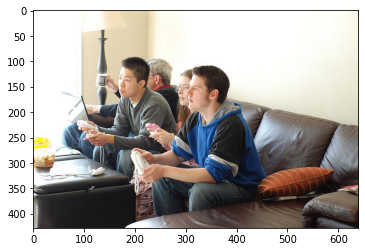

In [173]:
from PIL import Image

encoder.to(device) 
decoder.to(device)
encoder.eval()
decoder.eval()
original_img , _  = next(data_iter)
trans = transforms.ToPILImage()
input_image = trans(original_img[0].numpy())

captionize(input_image)